The purpose of this notebook is to document different manipulations to metagenomes done to normalize comparison of different metagenomes to eachother.

First, let's get an idea of the differences between these two metagenomes...

Renaming them to be either "illumina" or "pyro"

Folder created: ```/mnt/stepanauskas_nfs/julia/Test_FragRecruitment/Sakinaw/manmeta```

in this folder (so far):


```
illumina_joined_gt150.fastq.gz  pyro_gt150.fastq.gz
```

These reflect metagenomes created in the processes documented in the jupyter notebook "illumina_vs_pyro".

So many options on what to do next... for example:
* chop up 454 library into read sizes similar to the joined illumina reads
* decrease the size of the illumina library so that the bp space is similar between illumina and pyrosequenced metagenomes

So next we'll take a peak at the differences between these two metagenomes.

We've got some information from the join set for the illumina library:

In [1]:
!scp charlie:/mnt/stepanauskas_nfs/julia/fragdev/20160525/2079.6.1746.fastq_joinstats.txt ../data/i454comp/

2079.6.1746.fastq_joinstats.txt               100%  115     0.1KB/s   00:00    


In [2]:
!cat ../data/i454comp/2079.6.1746.fastq_joinstats.txt

metagenome	2079.6.1746.fastq
seqs_before_join	193290906
joined_pairs	71287501
total_bp	16752256254
mean_length	234


### *Illumina metagenome joined read size distribution:*

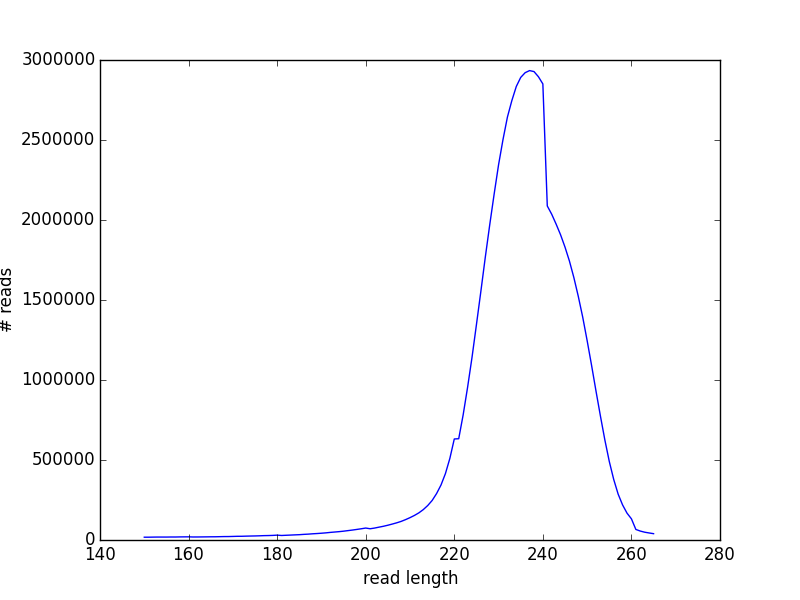

In [1]:
from IPython.display import Image

Image("../data/i454comp/2079.6.1746.fastq_joinstats.png")

Now to get the same set of information for the 454 read library... going to do this locally for better or worse.

In [9]:
import pandas as pd
import gzip
import os.path as op
from collections import defaultdict
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

from pysam import FastxFile

def readfx(fastx):
    fx = ""
    try:
        fx = FastxFile(fastx)
        for f in fx:
            yield f.name, f.sequence, f.quality
    finally:
        if fx:
            fx.close()
            
def plot_read_size(fastq):
    readsizes = defaultdict(lambda: 0)
    readcount = 0
    bpcount = 0
    for name, seq, qual in readfx(fastq):
        readsizes[len(seq)] += 1
        readcount += 1
        bpcount += len(seq)
    hist = pd.DataFrame.from_dict(readsizes, orient='index')
    hist['length']=hist.index
    hist['read_count']=hist[0]
    fig = plt.plot(hist['length'], hist['read_count'], color='b')
    plt.ylabel('# reads')
    plt.xlabel('read length')
    filename = op.dirname(fastq)+"_".join(op.basename(fastq).split(".")[:-1])+".png"
    name = "_".join(op.basename(fastq).split(".")[:-1])+".png"
    plt.title('%s: %s total reads' % (name, readcount))
    return plt, readcount, bpcount

In [10]:
pyroname = "../data/big_data/GZFH_454_gt150.fastq.gz"

The number of reads is: 554957 and the number of basepairs is: 206389798


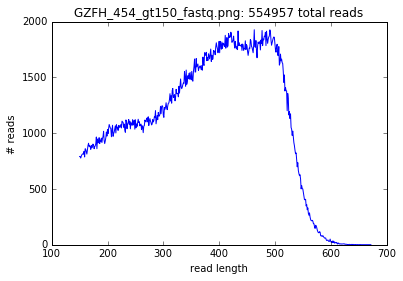

In [11]:
plt, readcount, bpcount = plot_read_size(pyroname)
print("The number of reads is:", readcount, "and the number of basepairs is:", bpcount)

In [13]:
meanbp = bpcount/readcount

In [14]:
import numpy as np

# from: http://stackoverflow.com/questions/5543651/computing-standard-deviation-in-a-stream
class OnlineVariance(object):
    """
    Welford's algorithm computes the sample variance incrementally.
    """

    def __init__(self, iterable=None, ddof=1):
        self.ddof, self.n, self.mean, self.M2 = ddof, 0, 0.0, 0.0
        if iterable is not None:
            for datum in iterable:
                self.include(datum)

    def include(self, datum):
        self.n += 1
        self.delta = datum - self.mean
        self.mean += self.delta / self.n
        self.M2 += self.delta * (datum - self.mean)
        self.variance = self.M2 / (self.n - self.ddof)

    @property
    def std(self):
        return np.sqrt(self.variance)
# example:   
N = 100
data = np.random.random(N)
ov = OnlineVariance(ddof=0)
for d in data:
    ov.include(d)
std = ov.std
print(std)

0.291297589008


In [15]:
def calc_size_sd(fastq):
    readsizes = defaultdict(lambda: 0)
    readcount = 0
    bpcount = 0
    size_var = OnlineVariance(ddof=0)
    for name, seq, qual in readfx(fastq):
        size_var.include(len(seq))
    std=size_var.std
    return std

In [16]:
calc_size_sd(pyroname)

108.5062047133632

In [19]:
def calc_libe_stats(fastq):
    readsizes = defaultdict(lambda: 0)
    readcount = 0
    bpcount = 0
    size_var = OnlineVariance(ddof=0)
    for name, seq, qual in readfx(fastq):
        size_var.include(len(seq))
        readsizes[len(seq)] += 1
        readcount += 1
        bpcount += len(seq)
    meanbp = bpcount/readcount
    readbp_std = size_var.std
    return pd.Series(data=[readcount, bpcount, meanbp, readbp_std], index=['read_count', 'bp_count', 'mean_read_len', 'read_len_std'])

In [20]:
ser = calc_libe_stats(pyroname)

In [37]:
ser = ser.rename('454_pyro')

In [38]:
illumina = pd.Series.from_csv("../data/i454comp/2079.6.1746.fastq_joinstats.txt", sep="\t")
illumina = illumina.rename(index={'joined_pairs': 'read_count', 'total_bp':'bp_count', 'mean_length':'mean_read_len'})
illumina = illumina.rename('illumina')

In [39]:
illumina

metagenome          2079.6.1746.fastq
seqs_before_join            193290906
read_count                   71287501
bp_count                  16752256254
mean_read_len                     234
Name: illumina, dtype: object

In [41]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)

In [42]:
pd.concat([ser, illumina], axis=1, join='inner')

,454_pyro,illumina
read_count,554957,71287501
bp_count,206389798,16752256254
mean_read_len,372,234


In [70]:
def chop_read(name, seq, qual, length, minimum):
    pieces = round(len(seq)/length)
    div = round(len(seq)/pieces)
    newrecords= ""
    for i, n in enumerate(range(0, len(seq), div)):
        newname = "%s_%s" % (name, i+1)
        newseq = seq[n:n+div]
        newqual = qual[n:n+div]
        if len(newseq) > minimum:
            newrecords += "@%s\n%s\n+\n%s\n" % (newname, newseq, newqual)
    return newrecords

In [71]:
name = "NS500409:16:H184TBGXX:1:11101:17876:1098 1:N:0:AGGCAGAA+AGAGGATA"
seq = "AAATTTTATTGAGGAGAATATCTAACCCATTACTCATAATCGCAGAAATTGATATTACTTCGGAAATGGATCCCTGATTCAATTTTCTTTCCAACTTTTTCAAGTTTTTTGCATCCAACAACTCTTTTTTATTCAGAACCAAAATCCTTGG"
qual = "<<AAAFFFFFFFFFFFAFFFFFF<.FFFAFFAFFFFFF.FFFFFFFFFFFFFFFAFFFFFFFFFFFFFFFFFFFFF.FAFFFFFFFFFFFFFFFFFFF<FFFFAFFFFFFFF7FFFFFFFFFFF)FFFFFFFFF<FAFF<FFF.FFFF7FF"

In [84]:
fqstring = chop_read(name, seq, qual, 15, 5)
print(fqstring)

@NS500409:16:H184TBGXX:1:11101:17876:1098 1:N:0:AGGCAGAA+AGAGGATA_1
AAATTTTATTGAGGA
+
<<AAAFFFFFFFFFF
@NS500409:16:H184TBGXX:1:11101:17876:1098 1:N:0:AGGCAGAA+AGAGGATA_2
GAATATCTAACCCAT
+
FAFFFFFF<.FFFAF
@NS500409:16:H184TBGXX:1:11101:17876:1098 1:N:0:AGGCAGAA+AGAGGATA_3
TACTCATAATCGCAG
+
FAFFFFFF.FFFFFF
@NS500409:16:H184TBGXX:1:11101:17876:1098 1:N:0:AGGCAGAA+AGAGGATA_4
AAATTGATATTACTT
+
FFFFFFFFFAFFFFF
@NS500409:16:H184TBGXX:1:11101:17876:1098 1:N:0:AGGCAGAA+AGAGGATA_5
CGGAAATGGATCCCT
+
FFFFFFFFFFFFFFF
@NS500409:16:H184TBGXX:1:11101:17876:1098 1:N:0:AGGCAGAA+AGAGGATA_6
GATTCAATTTTCTTT
+
F.FAFFFFFFFFFFF
@NS500409:16:H184TBGXX:1:11101:17876:1098 1:N:0:AGGCAGAA+AGAGGATA_7
CCAACTTTTTCAAGT
+
FFFFFFFF<FFFFAF
@NS500409:16:H184TBGXX:1:11101:17876:1098 1:N:0:AGGCAGAA+AGAGGATA_8
TTTTTGCATCCAACA
+
FFFFFFF7FFFFFFF
@NS500409:16:H184TBGXX:1:11101:17876:1098 1:N:0:AGGCAGAA+AGAGGATA_9
ACTCTTTTTTATTCA
+
FFFF)FFFFFFFFF<
@NS500409:16:H184TBGXX:1:11101:17876:1098 1:N:0:AGGCAGAA+AGAGGATA_10
GAACCAAAATCCT

In [82]:
def read_fq_string(fq_string):
    lines = fq_string.split("\n")
    for n in range(0, len(lines)-1, 4):
        name = lines[n].replace("@","")
        seq = lines[n+1]
        qual = lines[n+3]
        yield name, seq, qual

In [85]:
for n, s, q in read_fq_string(fqstring):
    print("name:", n)
    print("sequence:", s)
    print("qual:", q)

name: NS500409:16:H184TBGXX:1:11101:17876:1098 1:N:0:AGGCAGAA+AGAGGATA_1
sequence: AAATTTTATTGAGGA
qual: <<AAAFFFFFFFFFF
name: NS500409:16:H184TBGXX:1:11101:17876:1098 1:N:0:AGGCAGAA+AGAGGATA_2
sequence: GAATATCTAACCCAT
qual: FAFFFFFF<.FFFAF
name: NS500409:16:H184TBGXX:1:11101:17876:1098 1:N:0:AGGCAGAA+AGAGGATA_3
sequence: TACTCATAATCGCAG
qual: FAFFFFFF.FFFFFF
name: NS500409:16:H184TBGXX:1:11101:17876:1098 1:N:0:AGGCAGAA+AGAGGATA_4
sequence: AAATTGATATTACTT
qual: FFFFFFFFFAFFFFF
name: NS500409:16:H184TBGXX:1:11101:17876:1098 1:N:0:AGGCAGAA+AGAGGATA_5
sequence: CGGAAATGGATCCCT
qual: FFFFFFFFFFFFFFF
name: NS500409:16:H184TBGXX:1:11101:17876:1098 1:N:0:AGGCAGAA+AGAGGATA_6
sequence: GATTCAATTTTCTTT
qual: F.FAFFFFFFFFFFF
name: NS500409:16:H184TBGXX:1:11101:17876:1098 1:N:0:AGGCAGAA+AGAGGATA_7
sequence: CCAACTTTTTCAAGT
qual: FFFFFFFF<FFFFAF
name: NS500409:16:H184TBGXX:1:11101:17876:1098 1:N:0:AGGCAGAA+AGAGGATA_8
sequence: TTTTTGCATCCAACA
qual: FFFFFFF7FFFFFFF
name: NS500409:16:H184TBGXX:1:11

In [ ]:
def chop_reads(fastq, out_file, length, minlength, cores=10):
    
    if not out_file.endswith('.gz'):
        out_file = out_file + '.gz'
    
    if file_exists(out_file):
        print("output file exists, chop reads will not repeat itself.")
        return out_file
    
    p = multiprocessing.Pool(cores)
    
    original_count = 0
    readcount = 0
    bpcount = 0
    size_var = OnlineVariance(ddof=0)
    
    with file_transaction(out_file) as tx_outfile:
        with open(tx_outfile, "w") as txoh:
            for result in multiprocess(chop_read, readfx(fastq), 230, 150, pool=p):
                original_count += 1
                print(result, file=txoh)
                
                for name, seq, qual in read_fq_string(result):
                    readcount += 1
                    bpcount += len(seq)
                    size_var.include(len(seq))
    
    meanbp = bpcount/readcount
    readbp_std = size_var.std
    out_file = pigz_file(out_file, cores)
    
    outdata = pd.Series(data=[original_count, readcount, bpcount, meanbp, readbp_std], index=['original_count', 'read_count', 'bp_count', 'mean_read_len', 'read_len_std'])
    print(outdata)
    outdata.to_csv(outfile.replace("fastq.gz",".chop_data"), sep="\t")
    return out_file

Created script to chop reads based on above scratch, tested with 454 library.

In [91]:
!scp charlie:/mnt/stepanauskas_nfs/julia/Test_FragRecruitment/Sakinaw/manmeta/pyro_chopped_230.fastq.gz ../data/big_data/

pyro_chopped_230.fastq.gz                     100%  158MB  12.2MB/s   00:13    


(<module 'matplotlib.pyplot' from '//anaconda/envs/py3/lib/python3.5/site-packages/matplotlib/pyplot.py'>,
 897344,
 206270423)

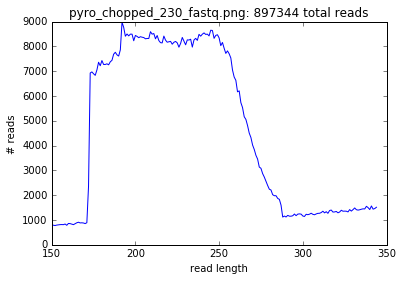

In [92]:
plot_read_size('../data/big_data/pyro_chopped_230.fastq.gz')

OK!  Now let's do some recruiting!

```
mg=Test_FragRecruitment/Sakinaw/manmeta/pyro_chopped_230.fastq.gz
log=0506_ncov.log
outdir=fragdev/20160604

parallel --retries 1 --bar --load 70% --joblog $log --jobs 3 python ~/scripts/rcov2.py \
print_cov --fastq $mg --reference {1} --outdir $outdir :::: firstlist.txt

parallel --retries 1 --bar --load 70% --joblog $log --jobs 3 python ~/scripts/rcov2.py \
print_cov --fastq $mg --reference {1} --outdir $outdir :::: thenthese.txt
```

```
outdir=/mnt/stepanauskas_nfs/julia/fragdev/20160604/
refdir=/mnt/stepanauskas_nfs/julia/Test_FragRecruitment/Sakinaw/Hallam_SAGs_AAA255/Masked_genomes_AAA255/

python ~/scripts/mp_recruit.py jrmr --fq1 $mg --outdir $outdir \
--refdir $refdir &> 0604_jrmr.log
```